# Data Wrangling for Prediction of Hospital Readmission in Diabetes Patients

## Introduction and a Note about the Data Source

Let's begin with the raw data set and its features, also known as variables. The table below gives a brief description of each one. The outcome, or dependent, variable is whether or not a patient was readmitted to a medical facility within 30 days. All other variables are predictors, or independent variables. This project aims to determine which of the predictors are most useful in predicting the outcome. 

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd 

#read in variable descriptions
pd.set_option('max_colwidth', 100)
variables = pd.read_csv('variable_description.csv')
variables

,Variable,Description
0,encounter ID,unique identifier of a patient visit
1,patient number,unique identifier of a patient
2,race,"values: Caucasian, Asian, African American, Hispanic, and other"
3,gender,"values: male, female, and unknown/invalid"
4,age,grouped in 10-year intervals up to 100
5,weight,patient weight in pounds
6,admission type,"integer indicating emergency, urgent, elective, newborn, and not available"
7,discharge disposition,"integer indicating discharged to home, expired, and not available"
8,admission source,"integer indicating physician referral, emergency room, and transfer from a hospital"
9,time in hospital,number of days between admission and discharge


This dataset was obtained from a previous study done to explore a similar problem. It included about 102,000 observations and 50 variables. More information is available here: http://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008. 

The first step is to just read in the data and preview its structure as rows and columns. Each row is one patient visit to a medical facility, and each column is a variable.

In [5]:
#read in raw data (from csv file)
readmitO = pd.read_csv('diabetic_data.csv')
readmitO.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [26]:
#check dimensions (rows and columns) to start
readmitO.shape

(101766, 50)

## Initial Adjustments to Variables

One particular column, the time spent in the hospital for a particular visit, is labeled a bit vaguely. Because this column specifically captures the number of days spent in a hospital, it makes sense to change the column label accordingly. This step will make interpretation easier in future analysis. 

Also, because the variable of interest here is whether or not a patient was readmitted within 30 days, it's important to simplify the way that variable's column in the dataset is read. So we'll change this variable to a binary, with 1 indicating that a patient was readmitted within 30 days and 0 indicating that a patient was not. 

In [27]:
#change time in hospital to more descriptive heading
readmit = readmitO.rename(columns = {'time_in_hospital':'days_in_hospital'})

#turn readmission variable into binary (readmitted w/in 30 days or not)
readmit['readmit30'] = np.where(readmit['readmitted'] == '<30', 1, 0)

## Removing Observations that May Cause Bias

Some patients have more than one observation (row) in the data set because they had more than one hospital visit. However, leaving additional encounters for a patient could skew the results toward outcomes for such patients since their data would be unfairly weighted and create observations that are not independent of each other. For example, if one patient had four hospital visits (encounters) and another patient had one, the four-encounter patient would have four rows of data in the data set, giving more weight to his data. Additionally, since each observation represents one encounter, multiple encounters for one patient likely aren't independent because subsequent visits could be follow-ups from an earlier visit. Maintaining independent observations is an essential step in statistical analysis to rule out underlying relationships in the data that a constructed model wouldn't account for. For those reasons, it makes sense to keep each patient's first visit and drop the others. (I keep the first visit rather than the last one since the original researchers did the same thing.)

Before removing these additional rows, though, it would help to capture the number of encounters per patient as a new variable. Patients who have had more visits to a medical facility may be more likely to be readmitted within 30 days, so let's make a new variable to indicate the number of visits for each patient before removing the additional encounters.

Finally, it will also help to remove observations that resulted in death or discharge to a hospice, since such patients would not be eligible for readmission within 30 days. Such observations will be dropped in the steps below, too. 

In [28]:
#create new variable indicating number of encounters patient has on record
readmit['num_visits'] = readmit.groupby('patient_nbr')['patient_nbr'].transform('count')

#check data frame (df) for desired result
readmit.sort_values(by = 'patient_nbr', ascending = True).head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,days_in_hospital,...,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,readmit30,num_visits
4267,24437208,135,Caucasian,Female,[50-60),?,2,1,1,8,...,No,No,No,No,No,Ch,Yes,<30,1,2
4780,26264286,135,Caucasian,Female,[50-60),?,1,1,7,3,...,No,No,No,No,No,Ch,Yes,>30,0,2
5827,29758806,378,Caucasian,Female,[50-60),?,3,1,1,2,...,No,No,No,No,No,No,No,NO,0,1
67608,189899286,729,Caucasian,Female,[80-90),?,1,3,7,4,...,No,No,No,No,No,No,Yes,NO,0,1
17494,64331490,774,Caucasian,Female,[80-90),?,1,1,7,3,...,No,No,No,No,No,Ch,Yes,NO,0,1


In [29]:
#check dimensions against initial ones 
readmit.shape

(101766, 52)

In [30]:
#reduce df so that there's one encounter per patient 

    #use lowest encounter_id, which indicates earliest visit by convention
readmit_sortP = readmit.sort_values(['patient_nbr', 'encounter_id'])
readmit_no_dups = readmit_sortP.drop_duplicates(['patient_nbr'])

    #remove bias in outcome variable by dropping encounters that resulted in death or discharge to hospice 
readmit_no_bias = readmit_no_dups[((readmit_no_dups.discharge_disposition_id != 11) & 
                                          (readmit_no_dups.discharge_disposition_id != 13) &
                                          (readmit_no_dups.discharge_disposition_id != 14) & 
                                          (readmit_no_dups.discharge_disposition_id != 19) & 
                                          (readmit_no_dups.discharge_disposition_id != 20) & 
                                          (readmit_no_dups.discharge_disposition_id != 21))] 
    #check results
discharge = readmit_no_bias.groupby('discharge_disposition_id').size()

## A Note About Missing Data

The next few sections handle the issue of missing data in various ways. To start, here is a preview of missing-observation counts for each feature of the data set. At the end of this notebook, we'll take a second look to make sure no missing values remain. 

On a technical note, it's helpful to create a copy of the existing data frame because we need to replace question marks (which are used for missing values originally) with NaN (which Python understands as NA). Keeping the question marks in place in the initial data frame will be useful for tracking the behavior of missing data later, hence the separate data frame with NaN values here. 

In [31]:
new_df = readmit_no_bias.copy() 
replaceQ = new_df.replace('?', np.NaN) 
checkNA = replaceQ.isnull().sum() #count remaining NA values to make sure there are 0
pd.options.display.max_rows = 60 #set preferences to display up to 60 rows in output
checkNA

encounter_id                    0
patient_nbr                     0
race                         1918
gender                          0
age                             0
weight                      67185
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
days_in_hospital                0
payer_code                  30415
medical_specialty           33639
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         10
diag_2                        293
diag_3                       1224
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

## Handling Variables with High Percentages of Missing Values

The original study that created my data set provided the following information on variables with missing data:

- weight: 97% missing
- medical specialty: 53% missing
- payer code: 52% missing
- race: 2% missing
- diagnosis 3: 1% missing
- The initial data set did not provide percentages for diagnosis 1 and diagnosis 2, but these features did have missing data. I found that each had less than 2% of their data missing. 

The variables with high percentages (greater than 50) of missingness will likely need to be removed from the data set, since it is hard to conclude that a relationship between two variables without having more than half the information from one variable. 

Before removing affected variables, though, it doesn't hurt to look for indications that the variable of interest could have a relationship with the outcome variable (readmission within 30 days). If the balance between the numbers of readmitted and non-readmitted patients is consistent across the values/categories of a variable, it's a sign that the data are missing at random. In that scenario, there's no underlying cause or relationship for the missingness, which would entail further investigation and leave us less comfortable about dropping the variable.

To start, I look at payer code and specialty of the attending physician since they are all missing more than 50% of their observations. Weight is dropped without investigation since nearly all of its data are missing. Variables with lower percentages of missing data will be addressed in the next section since they likely won't need to be removed entirely. 

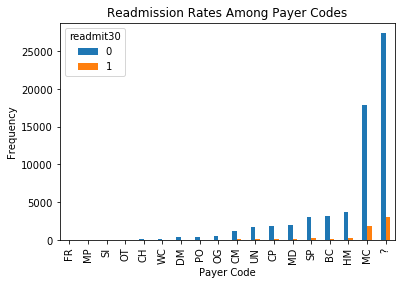

In [32]:
#Are readmission rates approximately even across payer codes, including the missing category? 

    #create cross-tab for initial evaluation and make sorted df for later bar plot
pay_code_ct = pd.crosstab(index = readmit_no_bias['payer_code'], columns = readmit_no_bias['readmit30'])
pay_code_df = pd.DataFrame(pay_code_ct.reset_index()).sort_values(by = 0)

    #make paired bar chart w/ payer codes -- The ? indicates the missing category. 
levels = pay_code_df.payer_code.tolist()
mapping = {level: i for i, level in enumerate(levels)} #assign nos. to levels 
key = pay_code_df['payer_code'].map(mapping) #map level ordinals to their rows in df
sorting = pay_code_df.iloc[key.argsort()] #create df w/ desired order from matched ordinals
ax = sorting.plot(kind = 'bar', x = 'payer_code', title = 'Readmission Rates Among Payer Codes')
ax.set_xlabel('Payer Code')
ax.set_ylabel('Frequency')
plt.show()

As the graph above shows, the balance of patients readmitted and not readmitted does not change very much across the different payer codes. There isn't much indication of readmission depending on payer code, so this feature can comfortably be removed from data set.

Next, since physician specialty has a similar percentage of missing data as payer code does, it will help to check for a pattern in missing data among physician specialty, too. However, a paired bar graph for 73 variables is tough to read; a better way is to visualize readmission percentages for each specialty. 

Medical specialties with fewer than 30 observations are removed, since small sample sizes don't offer strong indications of relationships. 30 is a particularly good cut-off point since it is a minimum sample size when using inferential methods like hypothesis tests and confidence intervals. In this part of my analysis, 30 is also just below the median number of observations per specialty, 36. 

Also note that in the table below, the first column is simply an index; it can be ignored during interpretation. 

In [33]:
#create data frame from cross tab
spec_ct = pd.crosstab(index = readmit_no_bias['medical_specialty'], columns = readmit_no_bias['readmit30'])
spec_df = pd.DataFrame(spec_ct.reset_index()).sort_values(by = 0, ascending = False)

#find total observations for each specialty and reduce to those less than 30
spec_df['total'] = spec_df[1] + spec_df[0]
m = spec_df['total'].median() #median no. of observations per specialty is 36
spec_df['readmit_pct'] = spec_df[1] / spec_df['total']
spec_trim = spec_df[(spec_df.total > 29)]

#rename columns and sort by readmission percentage
spec_named = spec_trim.rename(columns = {0:'not_readmit', 1:'readmitted'})
pd.set_option('display.max_rows', 75)
spec_named.sort_values(by = 'readmit_pct', ascending = False).head()

readmit30,medical_specialty,not_readmit,readmitted,total,readmit_pct
16,Hematology/Oncology,87,22,109,0.201835
26,Oncology,168,37,205,0.180488
42,PhysicalMedicineandRehabilitation,169,25,194,0.128866
68,Surgery-Vascular,316,43,359,0.119777
46,Psychiatry,545,68,613,0.110930


The readmission percentages range from 0 to 20, indicating that readmission percentages are not consistent across medical specialties. This variable may have an informative relationship with readmission rates, and data may not be missing at random. However, with more than 50% of data missing on medical specialty, most conclusions would not be too reliable in my opinion, so I remove the variable below. (The original researchers kept it, perhaps due to the patterns visible in the table above.)

In [34]:
#drop readmitted (old outcome), weight, payer code, and specialty of admitting physician  
readmit_drop = readmit_no_bias.drop(['readmitted', 'weight', 'medical_specialty', 'payer_code'], axis = 1)

## Handling Variables with Low Percentages of Missing Values 
The variables removed in the previous steps all had relatively high percentages of missing data. There are other variables with much lower percentages (less than 3%), which are handled differently here. Instead of removing the variable itself, we can often simply remove the observations with missing values for those variables. For example, instead of removing race, we remove only the observations that do not have a value recorded for race. (This change also reflects the difference between removing a column and a row in a data set.) 

When the percentage of missing data is low for a variable, the missing data are unlikely to affect the overall distribution of that variable. Thus, dropping observations with missing values is unlikely to artificially change the variable's predictive power. 

Since race can be related to socioeconomic indicators, it may be interesting to look at its relationship with the dependent variable before removing missing observations. In particular, it may be instructive to see if historically underserved races saw more frequent readmissions than other races did. The other variables with lower amounts of missing data are diagnostic codes, and their missing observations can readily be dropped. 

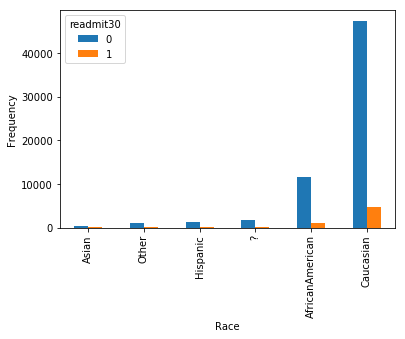

In [35]:
#look at relationship between race and readmissions

    #create cross-tab for initial evaluation and make df for later bar plot
race_ct = pd.crosstab(index = readmit_drop['race'], columns = readmit_drop['readmit30'])
race_df = pd.DataFrame(race_ct.reset_index()).sort_values(by = 0)

    #make paired bar chart w/ race
Rlevels = race_df.race.tolist()
Rmapping = {level: i for i, level in enumerate(Rlevels)} #assign nos. to levels 
Rkey = race_df['race'].map(Rmapping) #map level ordinals to their rows in df
Rsorting = race_df.iloc[Rkey.argsort()] #create df w/ desired order from matched ordinals
ax1 = Rsorting.plot(kind = 'bar', x = 'race') 
ax1.set_xlabel('Race')
ax1.set_ylabel('Frequency')
plt.show()

The graph above shows a pretty consistent balance in readmissions across races, so the available data doesn't show any evidence of higher readmissions rates among certain races. We can remove observations with missing data for race and diagnostic codes.

In [90]:
#remove observations w/ missing race and diagnoses 1, 2, and 3 (all have <2% of observations missing)
readmit_clean = readmit_drop[((readmit_drop.race != '?') & 
                                             (readmit_drop.diag_1 != '?') &
                                             (readmit_drop.diag_2 != '?') &
                                             (readmit_drop.diag_3 != '?'))]
readmit_clean.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,days_in_hospital,num_lab_procedures,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmit30,num_visits
4267,24437208,135,Caucasian,Female,[50-60),2,1,1,8,77,...,Steady,No,No,No,No,No,Ch,Yes,1,2
5827,29758806,378,Caucasian,Female,[50-60),3,1,1,2,49,...,No,No,No,No,No,No,No,No,0,1
67608,189899286,729,Caucasian,Female,[80-90),1,3,7,4,68,...,No,No,No,No,No,No,No,Yes,0,1
17494,64331490,774,Caucasian,Female,[80-90),1,1,7,3,46,...,No,No,No,No,No,No,Ch,Yes,0,1
2270,14824206,927,AfricanAmerican,Female,[30-40),1,1,7,5,49,...,No,No,No,No,No,No,No,Yes,0,1


## Categorizing Diagnostic Codes

Three different variables capture diagnosis codes for patient encounters. To the layperson, these codes do not make much sense. Fortunately, they can be grouped according to the condition they pertain to and thus more easily understood. So it makes sense to change the codes into conditions, which we'll do here. For example, code numbers 360-389 represent disorders of the sense organs; instead of having an assortment of numbers in that range, we can re-code them all as "sense disorder" to achieve more meaningful values. This adjustment will also expedite final analyses that rely on categorization and do not require the level of granularity that comes with initial diagnosis codes. 

In [93]:
# convert diagnoses with letters (E or V) to unique no. 
 # start by writing function to replace codes starting with E or V to 7777
def first_letter(col):
    if (col[0] == 'E' or col[0] == 'V'):
        return '7777'
    else:
        return col

In [128]:
 # create new, one-column dataframes with 7777 in place of E or V, then add to dataframe with new headings 
d1 = pd.DataFrame(readmit_clean.diag_1.apply(lambda col: first_letter(col)), dtype = 'float')
d2 = pd.DataFrame(readmit_clean.diag_2.apply(lambda col: first_letter(col)), dtype = 'float')
d3 = pd.DataFrame(readmit_clean.diag_3.apply(lambda col: first_letter(col)), dtype = 'float')

readmit_plus = pd.concat([readmit_clean, d1, d2, d3], axis = 1)
readmit_plus.columns.values[48:51] = ('Diag1', 'Diag2', 'Diag3')
readmit_plus.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,days_in_hospital,num_lab_procedures,...,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmit30,num_visits,Diag1,Diag2,Diag3
4267,24437208,135,Caucasian,Female,[50-60),2,1,1,8,77,...,No,No,No,Ch,Yes,1,2,401.0,997.0,560.0
5827,29758806,378,Caucasian,Female,[50-60),3,1,1,2,49,...,No,No,No,No,No,0,1,722.0,305.0,250.0
67608,189899286,729,Caucasian,Female,[80-90),1,3,7,4,68,...,No,No,No,No,Yes,0,1,820.0,493.0,7777.0
17494,64331490,774,Caucasian,Female,[80-90),1,1,7,3,46,...,No,No,No,Ch,Yes,0,1,274.0,427.0,416.0
2270,14824206,927,AfricanAmerican,Female,[30-40),1,1,7,5,49,...,No,No,No,No,Yes,0,1,590.0,220.0,250.0


In [129]:
# drop old diagnosis variables and check new df
no_placeH = readmit_plus.drop(['diag_1', 'diag_2', 'diag_3'], axis = 1)
no_placeH.head(10)

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,days_in_hospital,num_lab_procedures,...,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmit30,num_visits,Diag1,Diag2,Diag3
4267,24437208,135,Caucasian,Female,[50-60),2,1,1,8,77,...,No,No,No,Ch,Yes,1,2,401.0,997.0,560.00
5827,29758806,378,Caucasian,Female,[50-60),3,1,1,2,49,...,No,No,No,No,No,0,1,722.0,305.0,250.00
67608,189899286,729,Caucasian,Female,[80-90),1,3,7,4,68,...,No,No,No,No,Yes,0,1,820.0,493.0,7777.00
17494,64331490,774,Caucasian,Female,[80-90),1,1,7,3,46,...,No,No,No,Ch,Yes,0,1,274.0,427.0,416.00
2270,14824206,927,AfricanAmerican,Female,[30-40),1,1,7,5,49,...,No,No,No,No,Yes,0,1,590.0,220.0,250.00
18234,66197028,1305,Caucasian,Female,[60-70),3,1,1,9,52,...,No,No,No,No,Yes,0,1,491.0,428.0,250.01
15848,60254142,1314,Caucasian,Female,[40-50),2,1,1,2,50,...,No,No,No,No,Yes,0,3,996.0,411.0,401.00
61382,171414378,1629,Caucasian,Male,[70-80),3,6,4,14,21,...,No,No,No,No,Yes,0,1,7777.0,719.0,438.00
2279,14897280,2025,Caucasian,Female,[70-80),2,3,1,12,47,...,No,No,No,Ch,Yes,0,1,682.0,707.0,560.00
7866,36469686,3069,Caucasian,Male,[60-70),2,1,1,8,57,...,No,No,No,No,Yes,0,1,414.0,584.0,285.00


In [137]:
# write function to change diagnosis cols to categorical values
def cat_col(col):
    if (col >= 390) & (col <= 459) | (col == 785):
        return 'circulatory'
    elif (col >= 460) & (col <= 519) | (col == 786):
        return 'respiratory'
    elif (col >= 520) & (col <= 579) | (col == 787):
        return 'digestive'
    elif (col >= 250.00) & (col <= 250.99):
        return 'diabetes'
    elif (col >= 800) & (col <= 999):
        return 'injury'
    elif (col >= 710) & (col <= 739): 
        return 'musculoskeletal'
    elif (col >= 580) & (col <= 629) | (col == 788):
        return 'genitourinary'
    elif ((col >= 290) & (col <= 319) | (col == 7777) | 
          (col >= 280) & (col <= 289) | 
          (col >= 320) & (col <= 359) |
          (col >= 630) & (col <= 679) |
          (col >= 360) & (col <= 389) |
          (col >= 740) & (col <= 759)):
        return 'other'
    else:
        return 'neoplasms' 

In [139]:
# apply function to diagnosis columns to create new ones in df with categories
no_placeH['first_diag'] = no_placeH.Diag1.apply(lambda col: cat_col(col))
no_placeH['second_diag'] = no_placeH.Diag2.apply(lambda col: cat_col(col))
no_placeH['third_diag'] = no_placeH.Diag3.apply(lambda col: cat_col(col))
no_placeH.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,days_in_hospital,num_lab_procedures,...,change,diabetesMed,readmit30,num_visits,Diag1,Diag2,Diag3,first_diag,second_diag,third_diag
4267,24437208,135,Caucasian,Female,[50-60),2,1,1,8,77,...,Ch,Yes,1,2,401.0,997.0,560.0,circulatory,injury,digestive
5827,29758806,378,Caucasian,Female,[50-60),3,1,1,2,49,...,No,No,0,1,722.0,305.0,250.0,musculoskeletal,other,diabetes
67608,189899286,729,Caucasian,Female,[80-90),1,3,7,4,68,...,No,Yes,0,1,820.0,493.0,7777.0,injury,respiratory,other
17494,64331490,774,Caucasian,Female,[80-90),1,1,7,3,46,...,Ch,Yes,0,1,274.0,427.0,416.0,neoplasms,circulatory,circulatory
2270,14824206,927,AfricanAmerican,Female,[30-40),1,1,7,5,49,...,No,Yes,0,1,590.0,220.0,250.0,genitourinary,neoplasms,diabetes


## Remove Remaining Uneeded Variables and Adjust Column Names

Now that we've finished the wrangling process, we don't need certain identification features (patient ID and encounter ID). These numbers won't have predictive value since they are arbitrary and not valuable numerically. Nor do we need the remaining numerical diagnosis variables, as we've since produced more informative, textual versions of them. With that in mind, we can drop the ID and numerical-diagnosis features in preparation for further analysis. 

Our last small adjustment is to change the names of certain column headings that use hyphens, which Python doesn't read as part of a name. We'll change them to use underscores so that Python will read all column names smoothly. 

In [141]:
#drop unneeded columns
no_IDs = no_placeH.drop(['encounter_id', 'patient_nbr', 'Diag1', 'Diag2', 'Diag3'], axis = 1)

In [142]:
#change column headings that use hyphens
no_IDs.rename(columns={'glyburide-metformin': 'glyburide_metformin',
                       'glipizide-metformin': 'glipizide_metformin',
                       'glimepiride-pioglitazone': 'glimepiride_pioglitazone',
                       'metformin-rosiglitazone': 'metformin_rosiglitazone',
                       'metformin-pioglitazone': 'metformin_pioglitazone', }, inplace=True)

## Export Cleaned Data

Finally, we need to make sure no missing values remain. With all missing values handled, it's safe to write a new 
file that contains the cleaned data for use in exploratory and other analyses. It will help to have the cleaned data in two formats: one with the existing dataframe structure, and another with categorical variables mapped to groups of binary ones that can be easily interpreted in machine-learning methods like trees and logistic regression. 

In [143]:
#change all remaining ?s to NaN and check new dataframe
to_NaN = no_IDs.replace('?', np.NaN)
pd.options.display.max_rows = 75 #set preferences to show up to 60 rows in output
checkNA_end = to_NaN.isnull().sum() #count remaining NA values to make sure there are 0
checkNA_end

race                        0
gender                      0
age                         0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
days_in_hospital            0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol                    0
troglitazone                0
tolazamide                  0
examide                     0
citoglipton                 0
insulin   

In [146]:
#write csv for exploratory and other analyses
to_NaN.to_csv('readmit_for_map.csv', index = False)